# 0. Setup

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import librosa
import os
import IPython.display as ipd
from sklearn.model_selection import train_test_split

In [2]:
# Torch imports
import torch
import torchaudio
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchaudio.transforms import MelSpectrogram, Resample
from IPython.display import Audio
import torch.optim as optim

In [3]:
# Directories
DATA_DIR = "data/"
AUDIO_DIR = DATA_DIR + "train_audio/"

# Preprocessing info
SAMPLE_RATE = 32000 # All our audio uses this sample rate
SAMPLE_LENGTH = 5 # Duration we want to crop our audio to
NUM_SPECIES = 182 # Number of bird species we need to label

# Training hyperparameters
BATCH_SIZE = 16 # Number of batches while training our network
NUM_EPOCHS = 3 # Number of epochs to train our network
LEARNING_RATE = 0.001 # Learning rate for our optimizer


In [4]:
# Load data
data = pd.read_csv(DATA_DIR+"train_metadata.csv")
data['filepath'] = AUDIO_DIR + data['filename']

# We only need the filepath and species label
data = data[['filepath', 'primary_label']]

# Replace string labels by tensors whose entries are dummies
species = data['primary_label'].unique()
species_to_index = {species[i]:i for i in range(len(species))}
data['tensor_label'] = pd.Series(pd.get_dummies(data['primary_label']).astype(int).values.tolist()).apply(lambda x: torch.Tensor(x))
data.sample(5)

,filepath,primary_label,tensor_label
4317,data/train_audio/brwowl1/XC575193.ogg,brwowl1,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3552,data/train_audio/blrwar1/XC656466.ogg,blrwar1,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
22525,data/train_audio/whbbul2/XC366608.ogg,whbbul2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
17647,data/train_audio/litgre1/XC665314.ogg,litgre1,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
10312,data/train_audio/gloibi/XC388794.ogg,gloibi,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [5]:
# Train test split, stratified by species
data_train, data_test = train_test_split(data, test_size = 0.2, stratify=data['primary_label'])

# 2. Preprocessing and Generating Spectrograms

In [6]:
# Transforms audio signal to a spectrogram
spectrogram_transform = torchaudio.transforms.Spectrogram(
        n_fft=2048,
        win_length=2048,
        hop_length=512,
        power=2
    )

In [7]:
# Converts ordinary spectrogram to Mel scale
mel_spectrogram_transform = torchaudio.transforms.MelScale(
    n_mels=256,
    sample_rate=SAMPLE_RATE,
    f_min=0,
    f_max=16000,
    n_stft=1025  # the number of frequency bins in the spectrogram
)

In [8]:
# Scales decibels to reasonable level (apply to a spectrogram or Mel spectrogram)
db_scaler = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)

In [9]:
# Resizes spectrograms into square images
resize = transforms.Resize((224, 224), antialias = None)

In [10]:
# Takes a filepath and outputs a torch tensor with shape (1, 224, 224) 
# that we can feed into our CNN
def filepath_to_tensor(filepath):
    sample, _ = torchaudio.load(filepath)
    if len(sample) >= SAMPLE_RATE * SAMPLE_LENGTH:
        sample = sample[:SAMPLE_RATE * SAMPLE_LENGTH]
    else:
        pad_length = SAMPLE_RATE * SAMPLE_LENGTH - len(sample)
        sample = torch.nn.functional.pad(sample, (0, pad_length))
    spec = spectrogram_transform(sample)
    mel_spec = mel_spectrogram_transform(spec)
    db_scaled_mel_spec = db_scaler(mel_spec)
    resized = resize(db_scaled_mel_spec)
    return resized

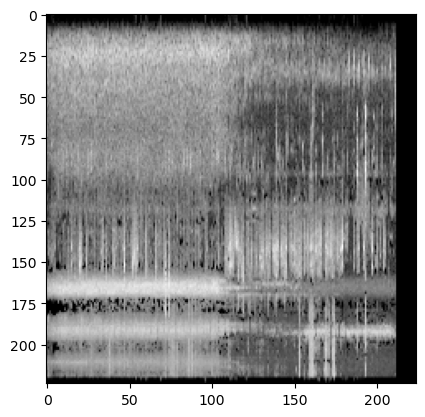

In [11]:
# Visualize a random spectrogram
t = filepath_to_tensor(data_train.sample()['filepath'].iloc[0])
plt.imshow(t.squeeze().numpy(), cmap='gray')
plt.show()

# 3. Defining Our Torch Dataset Class

In [12]:
# Note: filepaths and labels should be ordinary lists
class birdCLEF_dataset(Dataset):
    def __init__(self, filepaths, labels):
        super().__init__()
        self.filepaths = filepaths
        self.labels = labels

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index):
        processed_clip = filepath_to_tensor(self.filepaths[index])
        return processed_clip, self.labels[index]

# 4. Instantiate Our Dataset and a Dataloader

In [13]:
train_dataset = birdCLEF_dataset(filepaths = data_train['filepath'].to_list(), labels = data_train['tensor_label'].to_list())
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 5. Defining neural network architecture 

In [14]:
class birdClassifier(nn.Module):
    ''' Pared down architecture from https://github.com/musikalkemist/pytorchforaudio/blob/main/10%20Predictions%20with%20sound%20classifier/cnn.py'''
    def __init__(self, num_classes):
        super(birdClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=2,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.dropout = nn.Dropout(p=0.1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(25088, num_classes)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

model = birdClassifier(NUM_SPECIES)

# 6. Training

In [15]:
# Set our loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [16]:
print_per_n_batches = 100
print("Epoch     Batch")
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_per_n_batches == print_per_n_batches-1:    # print after some batches
            print(f'[{epoch + 1}/{NUM_EPOCHS}, {(i + 1):5d}/{len(dataloader)}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch     Batches processed
[1/3,   100/1223] loss: 4.920
[1/3,   200/1223] loss: 4.063
[1/3,   300/1223] loss: 3.934
[1/3,   400/1223] loss: 3.790
[1/3,   500/1223] loss: 3.513
[1/3,   600/1223] loss: 3.503
[1/3,   700/1223] loss: 3.447
[1/3,   800/1223] loss: 3.314
[1/3,   900/1223] loss: 3.413
[1/3,  1000/1223] loss: 3.197
[1/3,  1100/1223] loss: 3.119
[1/3,  1200/1223] loss: 3.170
[2/3,   100/1223] loss: 2.040
[2/3,   200/1223] loss: 2.101
[2/3,   300/1223] loss: 2.075
[2/3,   400/1223] loss: 2.182
[2/3,   500/1223] loss: 2.201
[2/3,   600/1223] loss: 2.183
[2/3,   700/1223] loss: 2.189
[2/3,   800/1223] loss: 2.368
[2/3,   900/1223] loss: 2.356
[2/3,  1000/1223] loss: 2.198
[2/3,  1100/1223] loss: 2.088
[2/3,  1200/1223] loss: 2.358
[3/3,   100/1223] loss: 0.909
[3/3,   200/1223] loss: 0.924
[3/3,   300/1223] loss: 0.928
[3/3,   400/1223] loss: 0.977
[3/3,   500/1223] loss: 1.053
[3/3,   600/1223] loss: 1.083
[3/3,   700/1223] loss: 1.166
[3/3,   800/1223] loss: 1.134
[3/3,   900/

# 7. Testing

In [27]:
test_dataset =  birdCLEF_dataset(filepaths = data_test['filepath'].to_list(), labels = data_test['tensor_label'].to_list())
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

losses = []
for i, data in enumerate(test_dataloader):
    inputs, labels = data
    pred = model(inputs)
    losses += [float(criterion(pred, labels))]

In [41]:
losses = pd.Series(losses)
losses.index = data_test.index
data_test['loss'] = losses

In [42]:
print(f"Average loss on test data: {data_test['loss'].sum() / len(data_test['loss'])}")

Average loss on test data: 3.9662700525699752


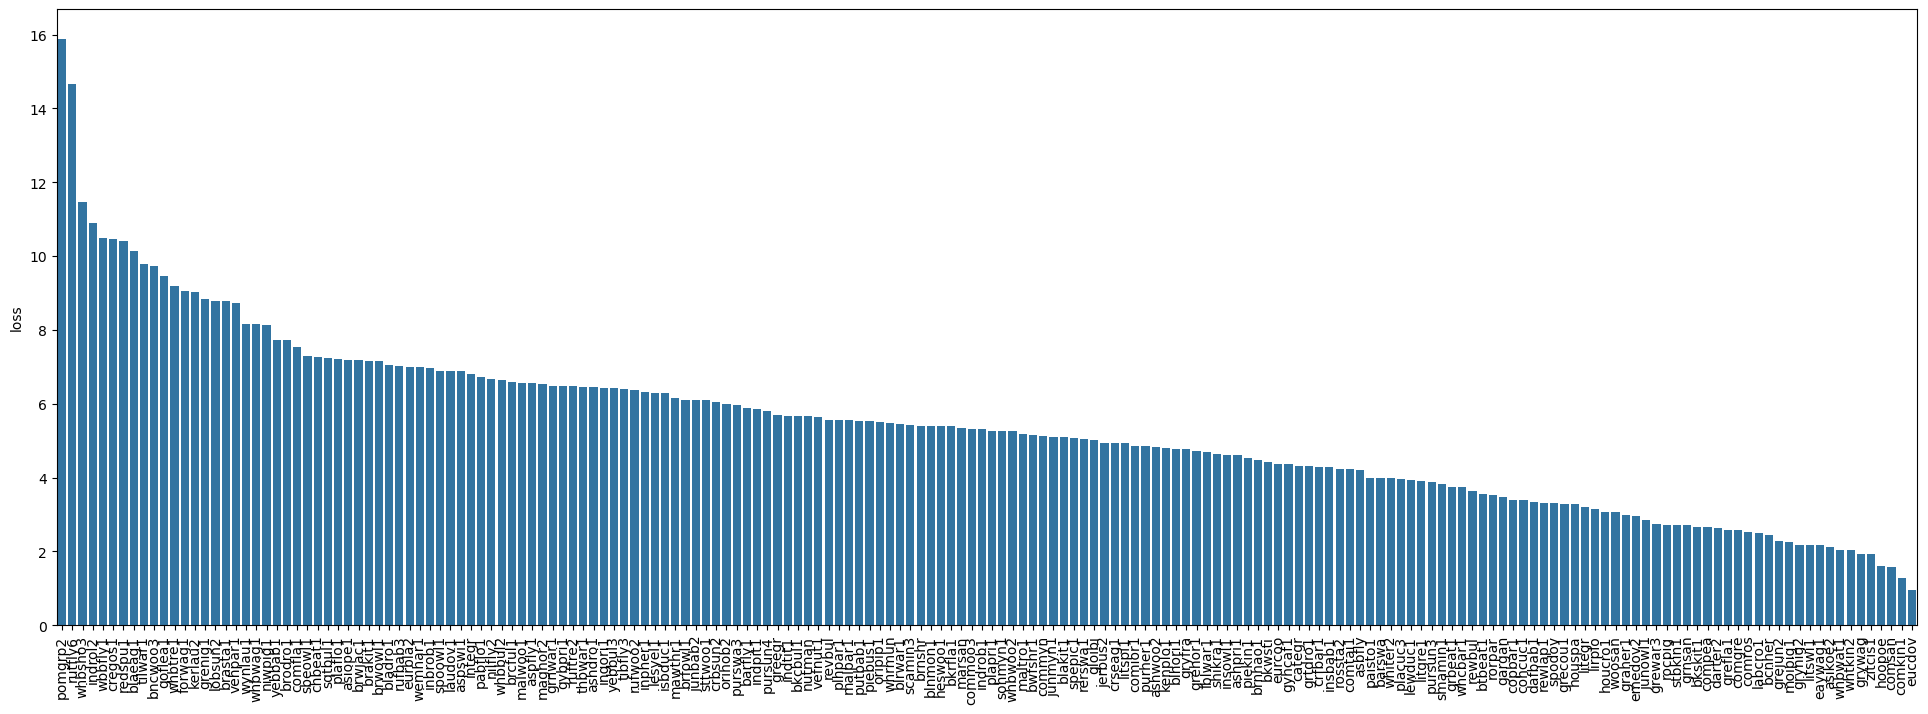

In [61]:
average_loss_by_species = pd.DataFrame(data_test.groupby(by = ['primary_label'])['loss'].mean()).sort_values(by='loss', ascending = False)
fig, ax = plt.subplots(figsize=(24, 8))
freqs = sns.barplot(data=average_loss_by_species, x='primary_label', y='loss', ax=ax)
freqs.set_xlabel("")
plt.xticks(rotation=90);